In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

In [2]:
concrete_data = pd.read_csv('https://raw.githubusercontent.com/Zaid-N-Ansari/PG-Mini-Project/refs/heads/main/Data/Concrete.csv')

print(f'Total Observations / Records: {concrete_data.shape[0]}')
print(f'Total Features / Columns / Variables: {concrete_data.shape[1]}')
print('Features:', end=' ')
col_names = concrete_data.columns.tolist()
print(*col_names, sep=', ')

Total Observations / Records: 1030
Total Features / Columns / Variables: 9
Features: cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength


In [3]:
concrete_data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
# Check for missing values
print("\nMissing values:")
print(concrete_data.isnull().sum())

# Check data types
print("\nData types:")
print(concrete_data.dtypes)

# Check for duplicates
print("\nNumber of duplicate rows:", concrete_data.duplicated().sum())

# Remove duplicates if any
concrete_data.drop_duplicates(inplace=True)
print("Shape of the dataset after removing duplicates:", concrete_data.shape)


Missing values:
cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

Data types:
cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object

Number of duplicate rows: 25
Shape of the dataset after removing duplicates: (1005, 9)


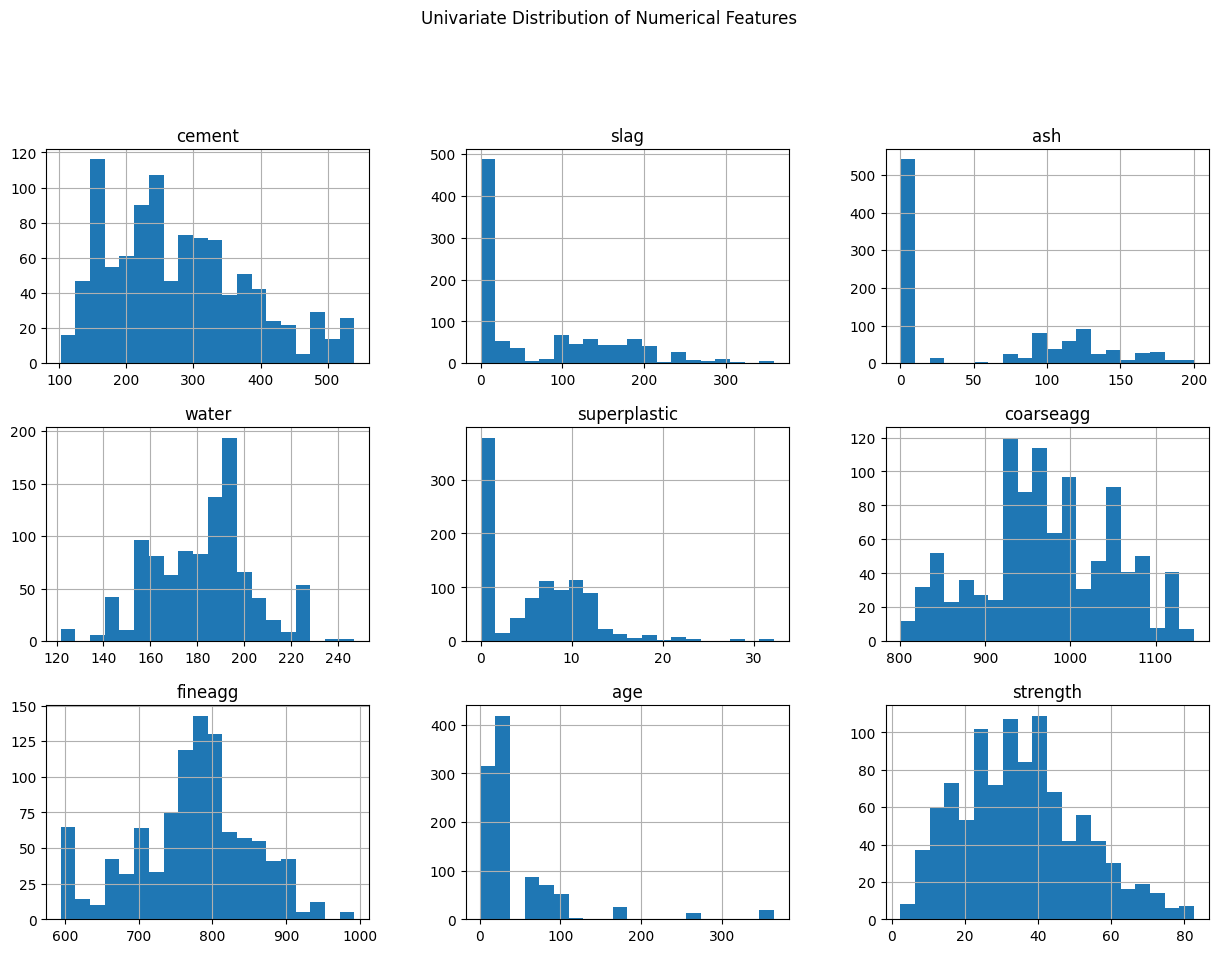

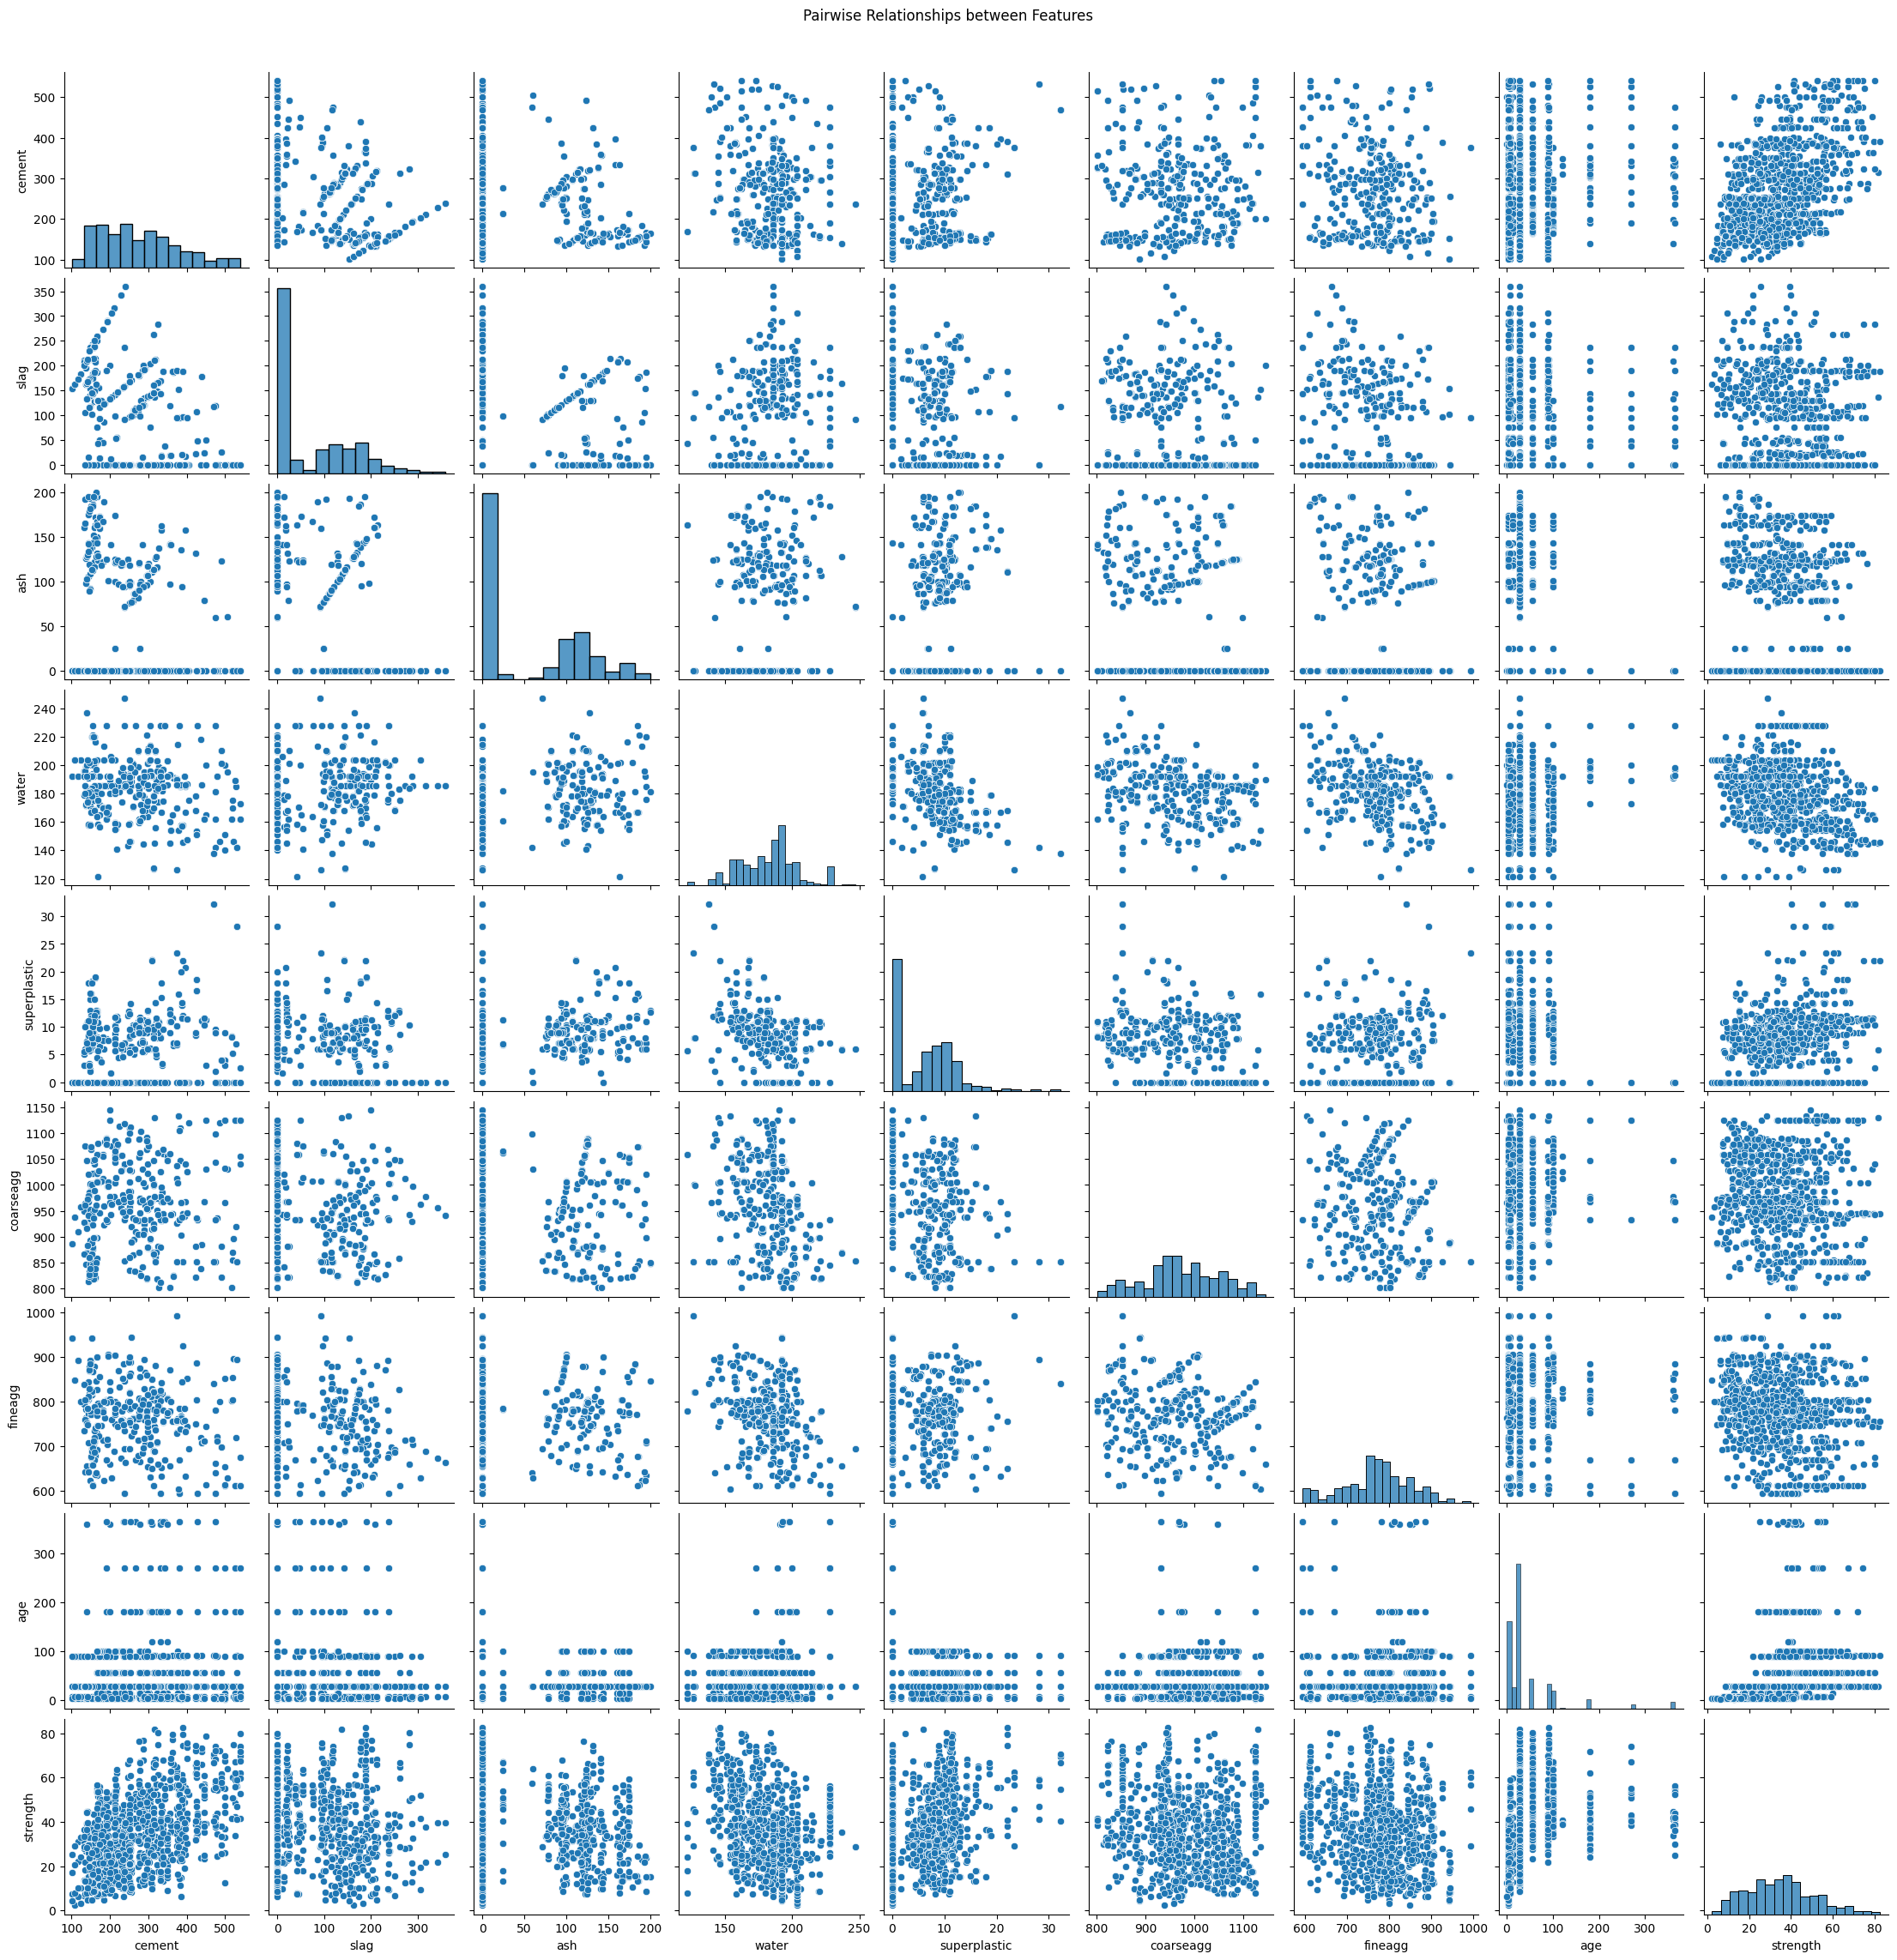

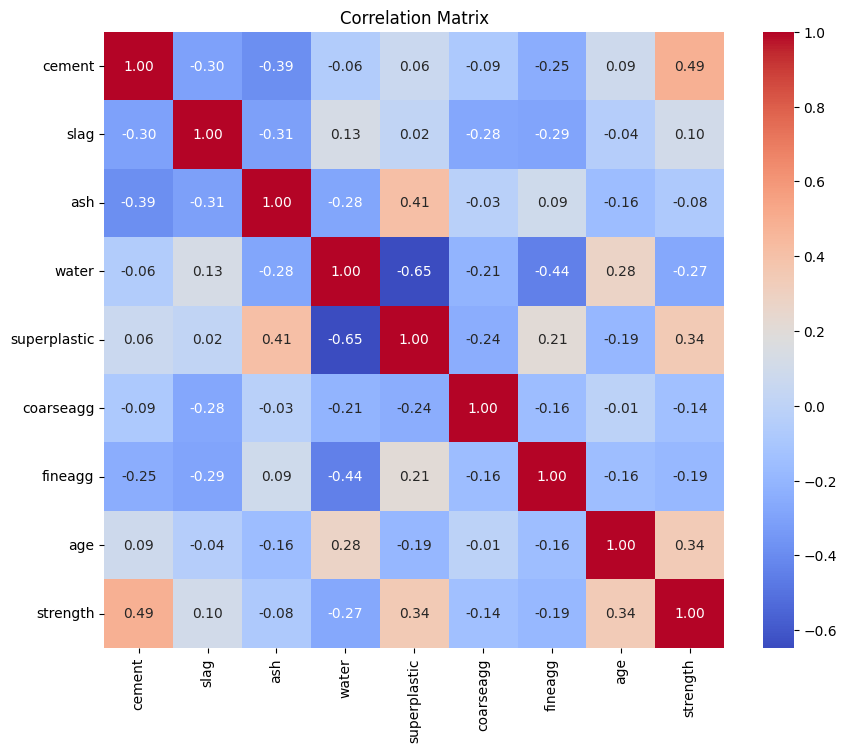

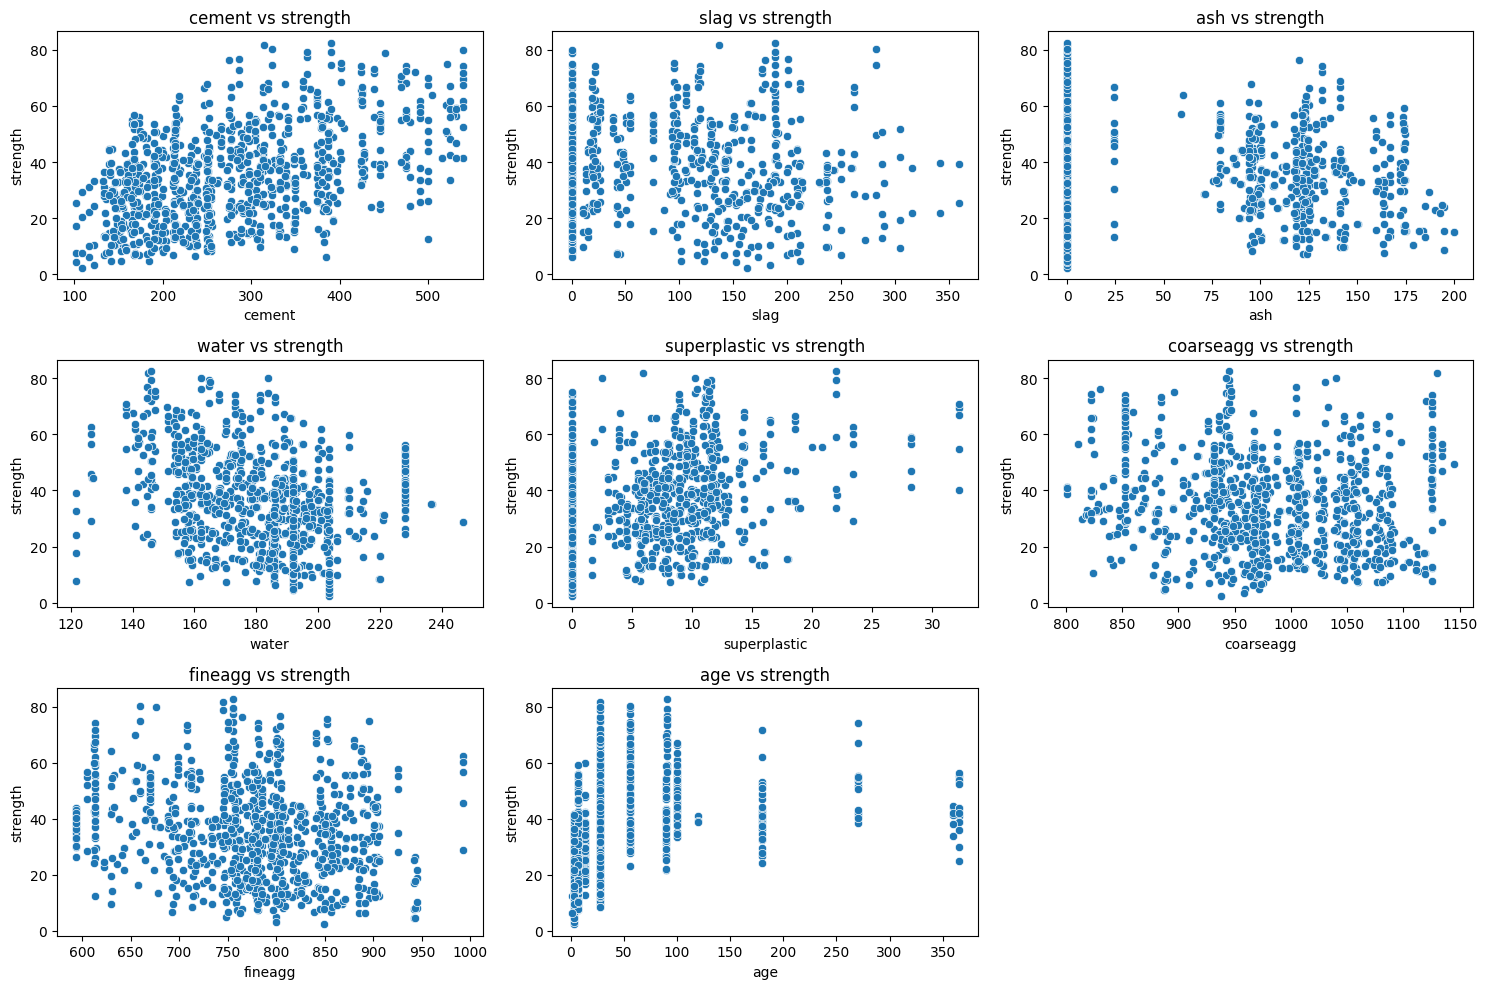

In [5]:
# i. Univariate Analysis
concrete_data.hist(bins=20, figsize=(15, 10))
plt.suptitle('Univariate Distribution of Numerical Features', y=1.02)
plt.show()

# ii. Bivariate Analysis
sns.pairplot(concrete_data)
plt.suptitle('Pairwise Relationships between Features', y=1.02)
plt.show()

# iii. Multivariate Analysis (Correlation Heatmap)
corr_mat = concrete_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Feature-target relationships
features = col_names[:-1]
target = 'strength'

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=concrete_data[feature], y=concrete_data[target])
    plt.title(f'{feature} vs {target}')
plt.tight_layout()
plt.show()

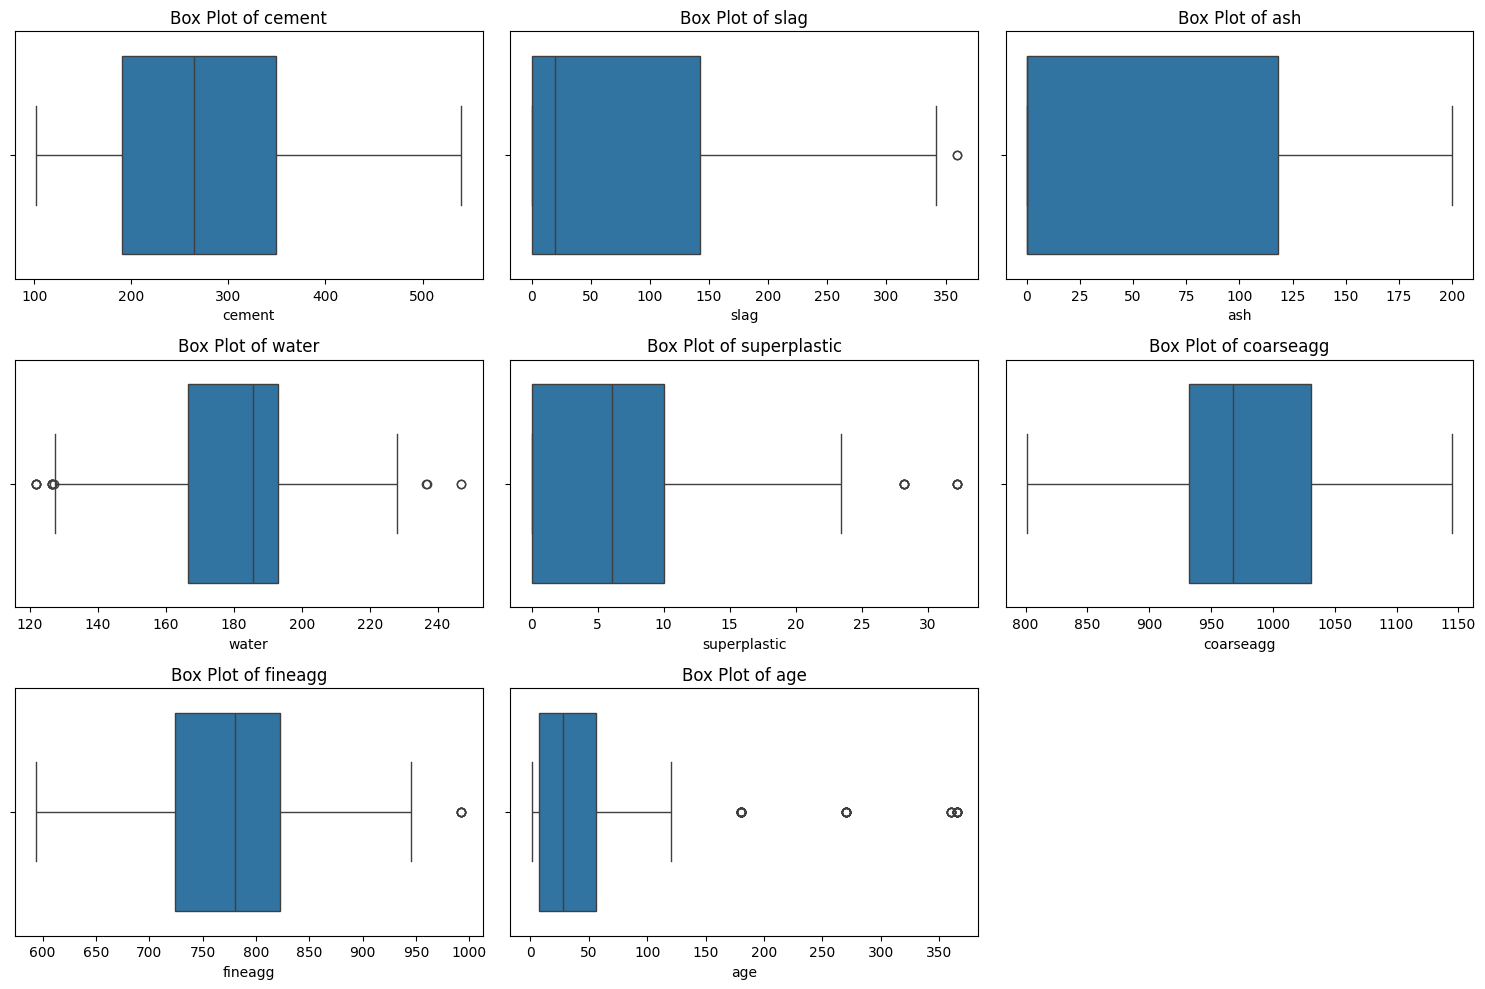

Shape of the dataset before outlier removal: (1005, 9)
Shape of the dataset after outlier removal: (919, 9)


In [6]:
# Boxplots to visualize outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=concrete_data[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

# Function to remove outliers using IQR method
def remove_outliers_iqr(concrete_data, column):
    Q1 = concrete_data[column].quantile(0.25)
    Q3 = concrete_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    concrete_data_filtered = concrete_data[(concrete_data[column] >= lower_bound) & (concrete_data[column] <= upper_bound)]
    return concrete_data_filtered

concrete_data_no_outliers = concrete_data.copy()
for col in features:
    concrete_data_no_outliers = remove_outliers_iqr(concrete_data_no_outliers, col)

print("Shape of the dataset before outlier removal:", concrete_data.shape)
print("Shape of the dataset after outlier removal:", concrete_data_no_outliers.shape)

# Let's proceed with the dataset after outlier removal for further steps
concrete_data = concrete_data_no_outliers


Skewness of features:
cement          0.587340
slag            0.819367
ash             0.380721
water           0.047865
superplastic    0.324577
coarseagg      -0.132846
fineagg        -0.282837
age             1.259133
dtype: float64

Kurtosis of features:
cement         -0.382661
slag           -0.568253
ash            -1.451343
water          -0.167639
superplastic   -0.647342
coarseagg      -0.563093
fineagg        -0.043315
age             0.644785
dtype: float64


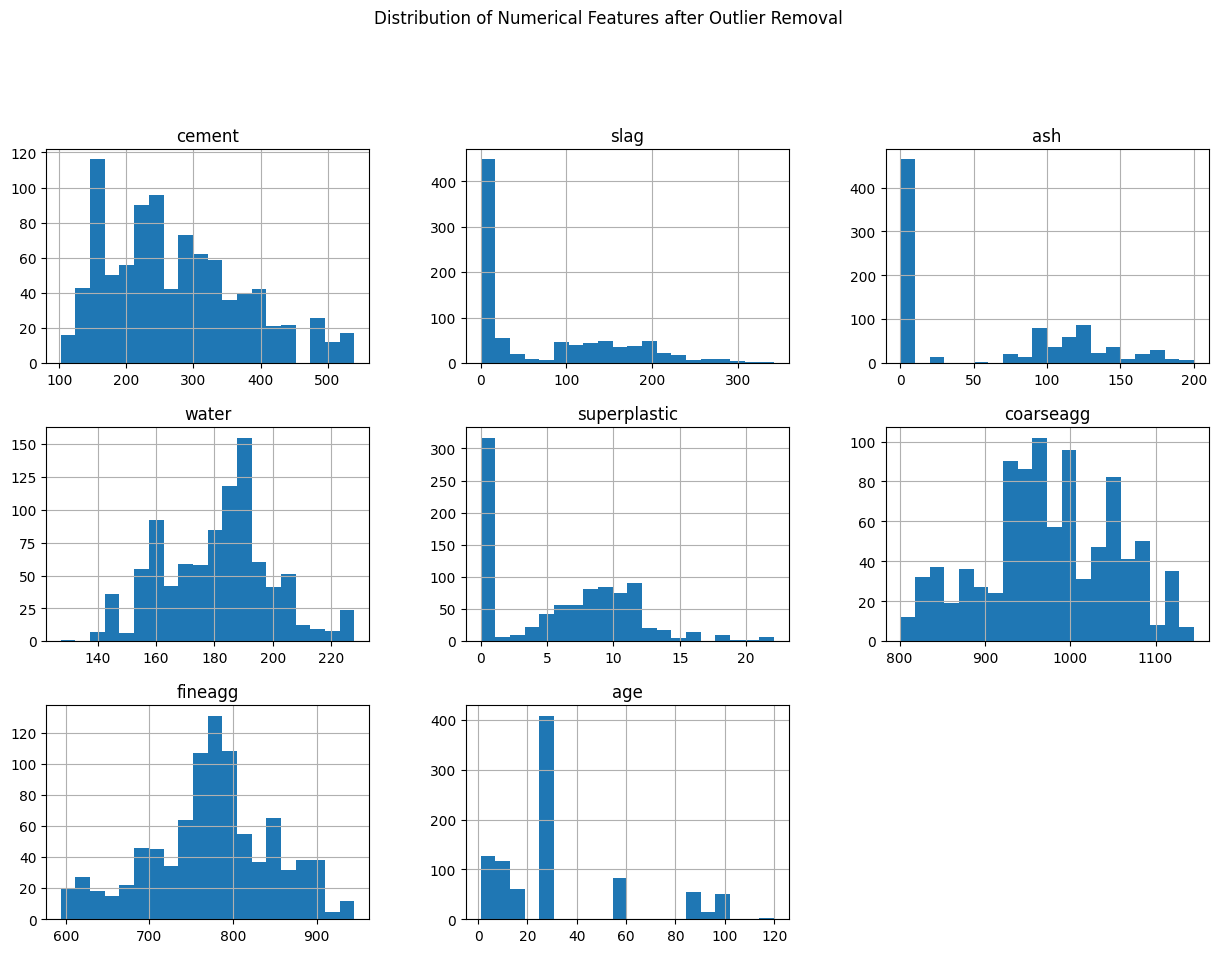

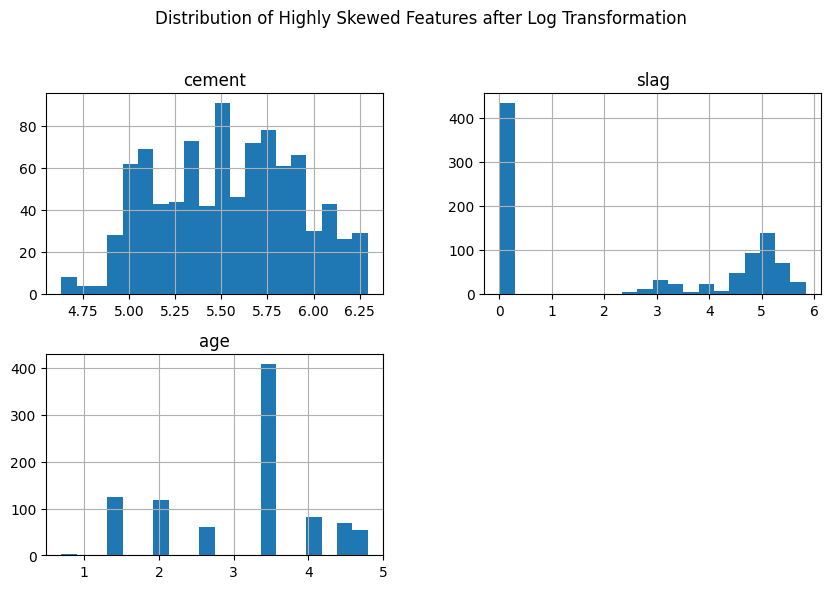


Skewness of features after transformation:
cement         -0.062761
slag            0.032494
ash             0.380721
water           0.047865
superplastic    0.324577
coarseagg      -0.132846
fineagg        -0.282837
age            -0.388086
dtype: float64


In [7]:
# Check Skewness and Kurtosis
print("\nSkewness of features:")
print(concrete_data[features].skew())
print("\nKurtosis of features:")
print(concrete_data[features].kurt())

# Visualize distributions after outlier removal
concrete_data[features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features after Outlier Removal', y=1.02)
plt.show()

# Apply Log Transformation to features with high positive skewness (e.g., age)
# We'll identify highly skewed features based on the skewness values
highly_skewed_features = concrete_data[features].skew()[abs(concrete_data[features].skew()) > 0.5].index

for feature in highly_skewed_features:
    concrete_data[feature] = np.log1p(concrete_data[feature])

# Visualize distributions after transformation
concrete_data[highly_skewed_features].hist(bins=20, figsize=(10, 6))
plt.suptitle('Distribution of Highly Skewed Features after Log Transformation', y=1.02)
plt.show()

print("\nSkewness of features after transformation:")
print(concrete_data[features].skew())

In [8]:
X = concrete_data.drop(target, axis=1)
y = concrete_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (735, 8)
Shape of X_test: (184, 8)
Shape of y_train: (735,)
Shape of y_test: (184,)


In [9]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_reg_scaled = LinearRegression()
linear_reg_scaled.fit(X_train_scaled, y_train)
y_pred_lr_scaled = linear_reg_scaled.predict(X_test_scaled)

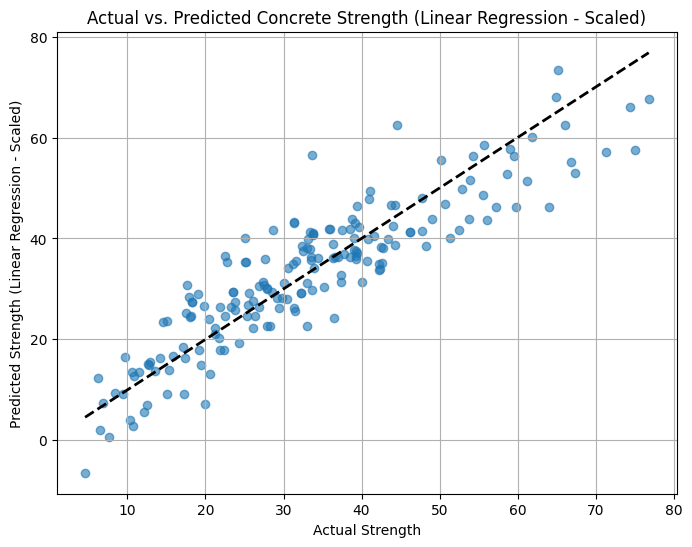

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr_scaled, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength (Linear Regression - Scaled)')
plt.title('Actual vs. Predicted Concrete Strength (Linear Regression - Scaled)')
plt.grid(True)
plt.show()

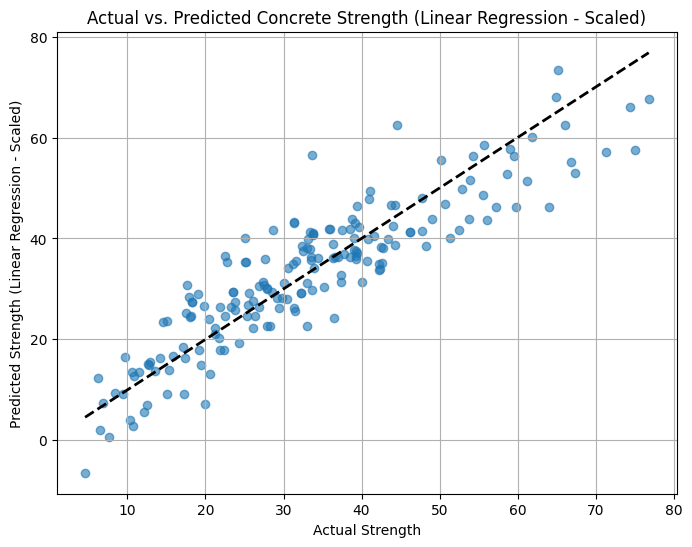

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr_scaled, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength (Linear Regression - Scaled)')
plt.title('Actual vs. Predicted Concrete Strength (Linear Regression - Scaled)')
plt.grid(True)
plt.show()

In [13]:
diff_lr_scaled = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr_scaled})
diff_lr_scaled['Difference'] = diff_lr_scaled['Actual'] - diff_lr_scaled['Predicted']
print("\nDifference between Actual and Predicted (Linear Regression - Scaled):")
print(diff_lr_scaled.head())


Difference between Actual and Predicted (Linear Regression - Scaled):
     Actual  Predicted  Difference
689   33.96  34.048256   -0.088256
777   36.30  36.046560    0.253440
934   33.08  39.910366   -6.830366
407    4.57  -6.422303   10.992303
194   23.79  25.825788   -2.035788


In [14]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X_test.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"\nPerformance Metrics for {model_name}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2 Score: {r2:.2f}")
    print(f"  Adjusted R2 Score: {adjusted_r2:.2f}")
    return mae, mse, rmse, r2, adjusted_r2

lr_metrics = evaluate_model(y_test, y_pred_lr_scaled, 'Linear Regression (Scaled)')


Performance Metrics for Linear Regression (Scaled):
  MAE: 5.45
  MSE: 46.74
  RMSE: 6.84
  R2 Score: 0.81
  Adjusted R2 Score: 0.80



Performance Metrics for Decision Tree Regressor:
  MAE: 4.67
  MSE: 51.95
  RMSE: 7.21
  R2 Score: 0.79
  Adjusted R2 Score: 0.78


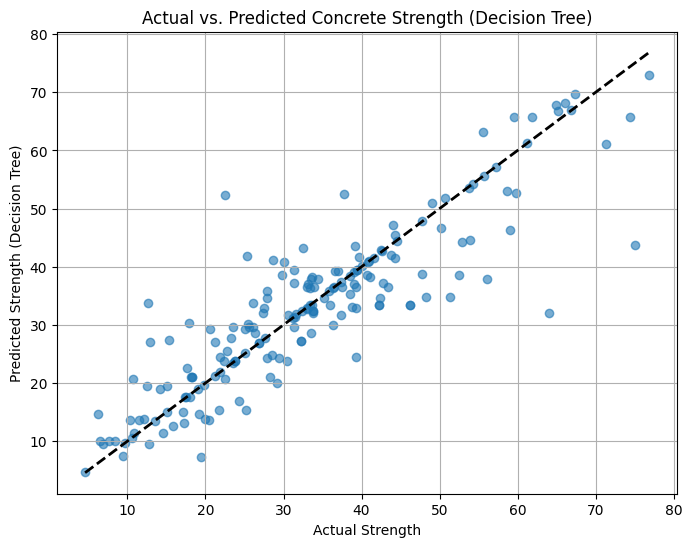


Performance Metrics for Random Forest Regressor:
  MAE: 3.76
  MSE: 26.42
  RMSE: 5.14
  R2 Score: 0.89
  Adjusted R2 Score: 0.89


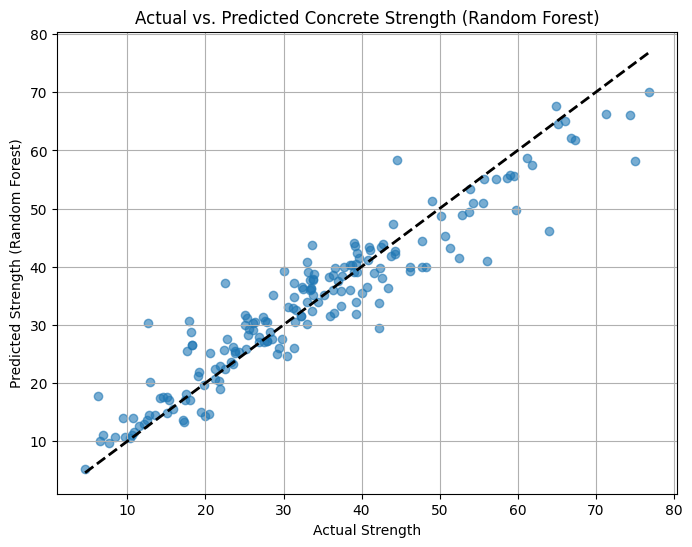


Performance Metrics for Support Vector Machine:
  MAE: 5.93
  MSE: 63.14
  RMSE: 7.95
  R2 Score: 0.74
  Adjusted R2 Score: 0.73


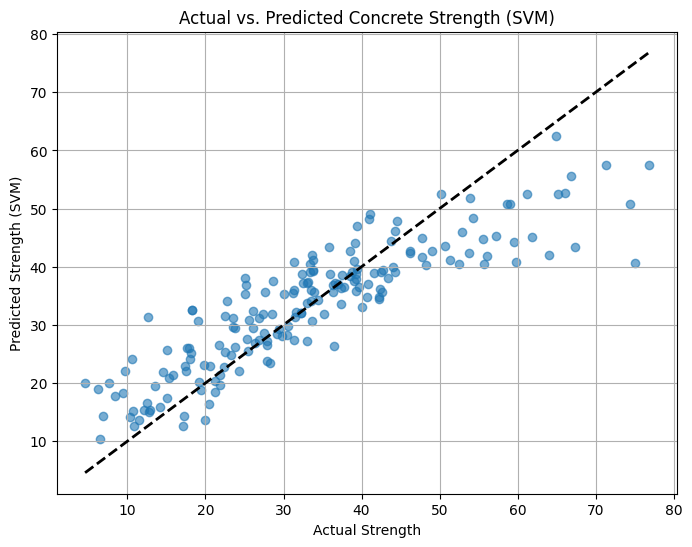


Performance Metrics for K-Nearest Neighbor:
  MAE: 5.07
  MSE: 47.77
  RMSE: 6.91
  R2 Score: 0.80
  Adjusted R2 Score: 0.79


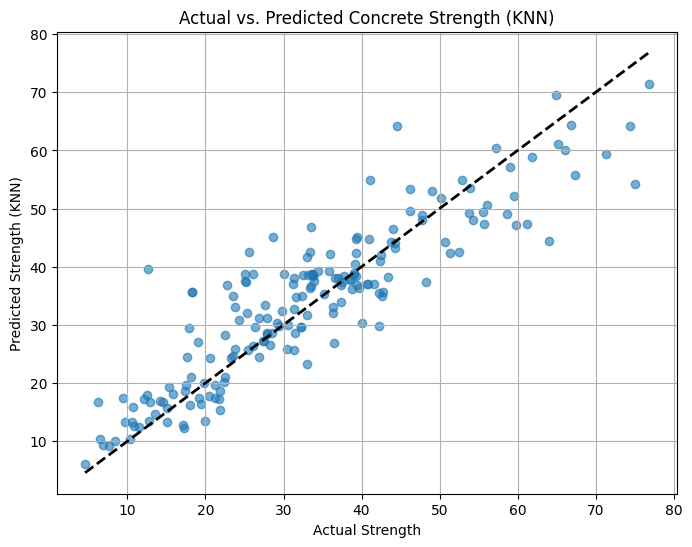

In [15]:
# --- Decision Tree Regressor ---
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train_scaled, y_train)
y_pred_dt = dt_reg.predict(X_test_scaled)
dt_metrics = evaluate_model(y_test, y_pred_dt, 'Decision Tree Regressor')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength (Decision Tree)')
plt.title('Actual vs. Predicted Concrete Strength (Decision Tree)')
plt.grid(True)
plt.show()

# --- Random Forest Regressor ---
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test_scaled)
rf_metrics = evaluate_model(y_test, y_pred_rf, 'Random Forest Regressor')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength (Random Forest)')
plt.title('Actual vs. Predicted Concrete Strength (Random Forest)')
plt.grid(True)
plt.show()

# --- Support Vector Machine ---
svm_reg = SVR()
svm_reg.fit(X_train_scaled, y_train)
y_pred_svm = svm_reg.predict(X_test_scaled)
svm_metrics = evaluate_model(y_test, y_pred_svm, 'Support Vector Machine')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svm, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength (SVM)')
plt.title('Actual vs. Predicted Concrete Strength (SVM)')
plt.grid(True)
plt.show()

# --- K-Nearest Neighbor ---
knn_reg = KNeighborsRegressor(n_neighbors=5) # You can experiment with different values of k
knn_reg.fit(X_train_scaled, y_train)
y_pred_knn = knn_reg.predict(X_test_scaled)
knn_metrics = evaluate_model(y_test, y_pred_knn, 'K-Nearest Neighbor')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_knn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength (KNN)')
plt.title('Actual vs. Predicted Concrete Strength (KNN)')
plt.grid(True)
plt.show()

In [16]:
cv = KFold(n_splits=5, shuffle=True)

def cross_validate_model(model, X, y, model_name):
    mae_scores = cross_val_score(model, X, y, cv=cv)
    mse_scores = cross_val_score(model, X, y, cv=cv)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

    print(f"\nCross-Validation Results for {model_name}:")
    print(f"  Mean MAE: {-mae_scores.mean():.2f} (+/- {mae_scores.std():.2f})")
    print(f"  Mean MSE: {-mse_scores.mean():.2f} (+/- {mse_scores.std():.2f})")
    print(f"  Mean R2 Score: {r2_scores.mean():.2f} (+/- {r2_scores.std():.2f})")

# Cross-validate the models (using scaled data where applicable)
cross_validate_model(LinearRegression(), X_test, y_test, 'Linear Regression')
cross_validate_model(DecisionTreeRegressor(), X_test, y_test, 'Decision Tree Regressor')
cross_validate_model(RandomForestRegressor(n_estimators=100), X_test, y_test, 'Random Forest Regressor')
cross_validate_model(SVR(), X_test, y_test, 'Support Vector Machine')
cross_validate_model(KNeighborsRegressor(n_neighbors=5), X_test, y_test, 'K-Nearest Neighbor')


Cross-Validation Results for Linear Regression:
  Mean MAE: -0.78 (+/- 0.06)
  Mean MSE: -0.78 (+/- 0.05)
  Mean R2 Score: 0.77 (+/- 0.08)

Cross-Validation Results for Decision Tree Regressor:
  Mean MAE: -0.49 (+/- 0.15)
  Mean MSE: -0.52 (+/- 0.13)
  Mean R2 Score: 0.51 (+/- 0.19)

Cross-Validation Results for Random Forest Regressor:
  Mean MAE: -0.73 (+/- 0.06)
  Mean MSE: -0.75 (+/- 0.08)
  Mean R2 Score: 0.77 (+/- 0.02)

Cross-Validation Results for Support Vector Machine:
  Mean MAE: 0.01 (+/- 0.02)
  Mean MSE: 0.04 (+/- 0.05)
  Mean R2 Score: -0.02 (+/- 0.03)

Cross-Validation Results for K-Nearest Neighbor:
  Mean MAE: -0.02 (+/- 0.22)
  Mean MSE: -0.08 (+/- 0.09)
  Mean R2 Score: 0.06 (+/- 0.26)


In [17]:
import re


print("\n\nFinal Conclusion:")

results = {
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor', 'Support Vector Machine', 'K-Nearest Neighbor'],
    'MAE': [lr_metrics[0], dt_metrics[0], rf_metrics[0], svm_metrics[0], knn_metrics[0]],
    'MSE': [lr_metrics[1], dt_metrics[1], rf_metrics[1], svm_metrics[1], knn_metrics[1]],
    'RMSE': [lr_metrics[2], dt_metrics[2], rf_metrics[2], svm_metrics[2], knn_metrics[2]],
    'R2 Score': [lr_metrics[3], dt_metrics[3], rf_metrics[3], svm_metrics[3], knn_metrics[3]],
    'Adjusted R2': [lr_metrics[4], dt_metrics[4], rf_metrics[4], svm_metrics[4], knn_metrics[4]]
}

results_df = pd.DataFrame(results)
print("\nPerformance Comparison on Test Set:")

print("\nCross-Validation Summary:")
print("Based on the cross-validation results, the Random Forest Regressor and potentially Support Vector Machine tend to show promising performance in predicting concrete compressive strength. However, the best model might depend on the specific requirements of the application, such as interpretability versus prediction accuracy.")

print("\nFurther Considerations:")
print("- Hyperparameter tuning for each model could potentially improve their performance.")
print("- Exploring other feature engineering techniques based on domain knowledge might be beneficial.")
print("- Gathering more data could lead to more robust and accurate models.")

results_df.index = results_df.index + 1  # Start index from 1 for better readability
results_df



Final Conclusion:

Performance Comparison on Test Set:

Cross-Validation Summary:
Based on the cross-validation results, the Random Forest Regressor and potentially Support Vector Machine tend to show promising performance in predicting concrete compressive strength. However, the best model might depend on the specific requirements of the application, such as interpretability versus prediction accuracy.

Further Considerations:
- Hyperparameter tuning for each model could potentially improve their performance.
- Exploring other feature engineering techniques based on domain knowledge might be beneficial.
- Gathering more data could lead to more robust and accurate models.


,Model,MAE,MSE,RMSE,R2 Score,Adjusted R2
1,Linear Regression,5.450759,46.743863,6.836948,0.807016,0.798194
2,Decision Tree Regressor,4.671005,51.947997,7.207496,0.785530,0.775726
3,Random Forest Regressor,3.761788,26.420725,5.140109,0.890921,0.885934
4,Support Vector Machine,5.925722,63.138256,7.945958,0.739331,0.727415
5,K-Nearest Neighbor,5.067728,47.772907,6.911795,0.802767,0.793751
